In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
from stop_words import get_stop_words

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
articles = pd.read_csv('/kaggle/input/covid19-singapore-policies-dataset/News Article/articles1.csv')
content = articles["content"]
content = content.drop_duplicates()

In [4]:
def text_preprocessing(text):
    
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words.extend(nltk_words)
    stopwords_dict = Counter(stop_words)
    
    # Convert words to lower case
    text = text.lower()

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize and remove stop words
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1 and not token in stopwords_dict and token.isalpha()]
    
    return text

In [5]:
# Create a list of review by applying text_preprocessing function
test_with_emp = list(map(text_preprocessing, content))
test = list()



In [6]:

for i in test_with_emp:
    if len(i) != 0: test.append(i)

In [7]:
import gensim

# Create Dictionary
id2word = gensim.corpora.Dictionary(test)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(word) for word in test]
          

In [8]:
from gensim.models import CoherenceModel
import seaborn as sns

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(5,20):
    print(i)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=test, 
                                       dictionary=id2word, 
                                       coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [9]:
topic_coherence

,number_of_topics,coherence_score
0,5,0.343840
1,6,0.374086
2,7,0.356194
3,8,0.388078
4,9,0.396162
5,10,0.408861
6,11,0.398312
7,12,0.439729
8,13,0.438579
9,14,0.406566


<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score'>

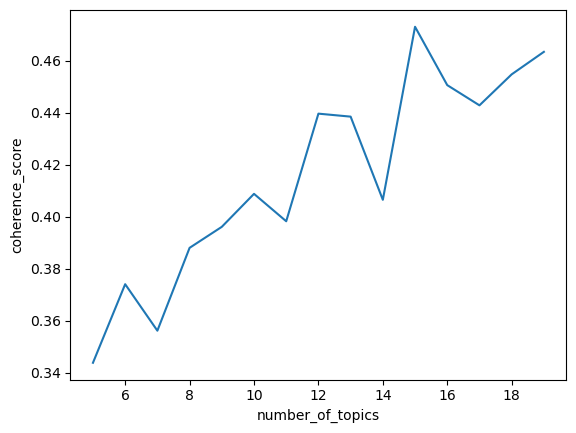

In [10]:
# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score') #5:20 50

In [11]:
# Define the number of topics 
n_topics = 18

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [12]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(lda_model, open(filename, 'wb'))

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.303573 -0.025084       1        1  35.054400
3     -0.286511 -0.084582       2        1  15.483502
0     -0.273989 -0.019417       3        1  15.201379
15    -0.195208 -0.066090       4        1   8.165490
5     -0.162145 -0.055612       5        1   5.792064
16    -0.242500  0.045407       6        1   5.724289
11    -0.145496 -0.068589       7        1   5.081645
2     -0.032916  0.224629       8        1   2.612905
8     -0.046590 -0.177335       9        1   2.503913
10    -0.059130  0.325780      10        1   1.403606
13     0.143407  0.081751      11        1   0.707123
7      0.180742  0.080259      12        1   0.558561
9      0.149848 -0.012107      13        1   0.546779
4      0.230390 -0.037109      14        1   0.331679
17     0.263573 -0.055950      15        1   0.262239
14     0.246016 -0.051090      16        1   0.257750
12     0.237927 -0.048856      17        1   0.235051
1      0.296153 -0.056006      18        1   0.077622, topic_info=           Term           Freq          Total Category  logprob  loglift
274       trump  302815.000000  302815.000000  Default  30.0000  30.0000
171         new  106609.000000  106609.000000  Default  29.0000  29.0000
2107       news   38746.000000   38746.000000  Default  28.0000  28.0000
1338    company   46829.000000   46829.000000  Default  27.0000  27.0000
251       state  121424.000000  121424.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
3381     agency       0.067258       1.764882  Topic18 -12.2088   3.8938
3322     likely       0.067274       1.768299  Topic18 -12.2086   3.8921
4353  wednesday       0.067260       1.765746  Topic18 -12.2088   3.8933
3379       vote       0.067275       1.770146  Topic18 -12.2086   3.8911
5179   sessions       0.067257       1.765552  Topic18 -12.2088   3.8934

[919 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1738      7  0.981987   abbas
3139      1  0.999777  accept
298       1  0.236180  accord
298       2  0.197843  accord
298       5  0.079906  accord
...     ...       ...     ...
1236      1  0.073188   young
1236      3  0.273295   young
1236      5  0.520841   young
1236      6  0.034938   young
1236      8  0.097694   young

[1427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 16, 6, 17, 12, 3, 9, 11, 14, 8, 10, 5, 18, 15, 13, 2])

In [14]:
import pickle
filename = 'model_vis.sav'
pickle.dump(vis, open(filename, 'wb'))